## Análisis del avance de la COVID-19
_Mauricio Alvarado_

En este documento tiene como objetivo analizar los `casos confirmados` y las `muertes` por COVID-19. En particular, se trabajará con la data del repositorio de la `Johns Hopkins University` para Latinoamérica durante todo el periodo de la pandemia 2020-2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

Se importa directamente la data más actualizada desde el repositorio de `Johns Hopkins University` en `GitHub`. Se importarán los casos y las muertes en dos diferentes DataFrames

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
dta_cases = pd.read_csv(url)

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
dta_deaths = pd.read_csv(url)

Se define una lista que cuenta con el nombre de todos los países de Latinoamérica, al igual que los dos `DataFrames` con los que se trabajará

In [3]:
latam_countries = ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"]

latam_cases = pd.DataFrame()
latam_deaths = pd.DataFrame()

Se va a filtrar únicamente los datos de Latinoamérica del total del repositorio

In [4]:
for country in latam_countries:
    country = dta_cases[dta_cases["Country/Region"] == country]
    latam_cases = pd.concat([latam_cases, country])
    
for country in latam_countries:
    country = dta_deaths[dta_deaths["Country/Region"] == country]
    latam_deaths = pd.concat([latam_deaths, country])

Se limpia las columnas que no es de nuestro interés

In [5]:
latam_cases.drop(["Province/State", "Lat", "Long"], axis = 1, inplace = True)
latam_deaths.drop(["Province/State", "Lat", "Long"], axis = 1, inplace = True)

Se coloca como `index` el nombre de cada país

In [6]:
latam_cases.set_index("Country/Region", inplace = True)
latam_deaths.set_index("Country/Region", inplace = True)

latam_cases.index.name = None
latam_deaths.index.name = None

Se transpone la tabla para tener el nombre de cada uno de los países en cada columna. El nuevo `index` será las fechas con las que se cuenta registro, por lo que sería ideal colocarlo en formato `datetime`

In [7]:
latam_cases = latam_cases.T
latam_deaths = latam_deaths.T

latam_cases.index = pd.to_datetime(latam_cases.index)
latam_deaths.index = pd.to_datetime(latam_deaths.index)

In [8]:
latam_deaths.tail()

,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Guyana,Paraguay,Peru,Suriname,Uruguay,Venezuela
2022-07-15,129145,21979,675090,58990,140365,35769,1264,19083,213769,1377,7373,5745
2022-07-16,129145,21979,675295,59039,140365,35769,1264,19083,213801,1377,7373,5747
2022-07-17,129202,21982,675350,59086,140365,35769,1266,19083,213801,1377,7373,5748
2022-07-18,129202,21982,675518,59126,140365,35774,1267,19083,213840,1377,7373,5748
2022-07-19,129202,21989,675871,59140,140365,35774,1267,19083,213870,1379,7387,5748


Finalmente, el avance en los casos se representa por el siguiente gráfico:

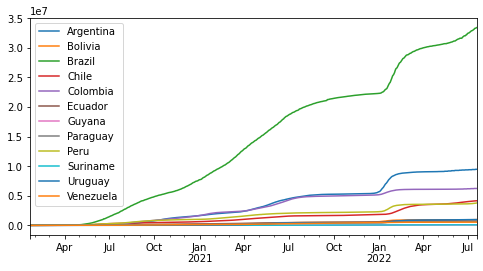

In [9]:
latam_cases.plot(kind = "line", figsize = (8,4))
plt.show()

### Peru: Data Wrangling
Para el caso particular de Perú, crearé un DataFrame que contenga únicamente los datos para este país

In [10]:
peru_data = latam_cases[["Peru"]].rename(columns = {"Peru": "Casos"})
peru_data = pd.concat([peru_data, latam_deaths["Peru"]], axis = 1)

peru_data.rename(columns = {"Peru": "Muertes"}, inplace = True)

In [11]:
peru_data

,Casos,Muertes
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2022-07-15,3729879,213769
2022-07-16,3740861,213801
2022-07-17,3740861,213801
2022-07-18,3761445,213840


Se crean dos columnas que son los nuevos casos y muertes diarias. En ambos casos, la mecánica es sacar primeras diferencias

In [12]:
peru_data["Nuevos Casos"] = peru_data["Casos"] - peru_data["Casos"].shift(1)
peru_data["Nuevas Muertes"] = peru_data["Muertes"] - peru_data["Muertes"].shift(1)

Se reemplaza los valores `NaN` con missing values, y se estandariza los nuevos casos en miles de personas

In [13]:
peru_data = peru_data.replace('NaN', np.NaN)

peru_data[["Casos", "Nuevos Casos"]] = peru_data[["Casos", "Nuevos Casos"]]/1000

Por lo general, es más informativo observar un gráfico con un `moving average` de los últimos siete días:

In [14]:
peru_data["Nuevos Casos MA7"] = peru_data["Nuevos Casos"].rolling(window=7).mean()
peru_data["Nuevas Muertes MA7"] = peru_data["Nuevas Muertes"].rolling(window=7).mean() 

Eliminamos los missing values mediante el comando `dropna`

In [15]:
peru_data = peru_data.dropna()

### Perú: Visualizations

En primer lugar, se puede presentar los casos de Perú, según diferentes olas de la Covid-19

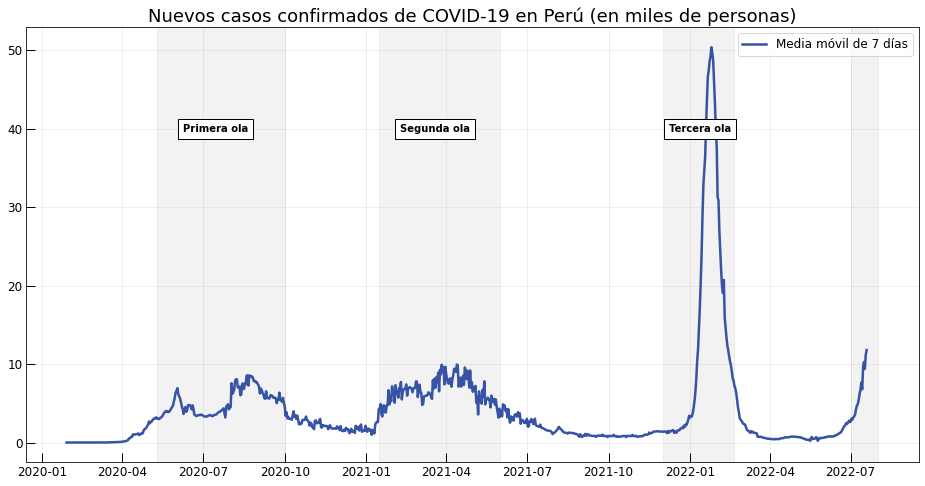

In [16]:
plt.figure(figsize=(16, 8), linewidth = 2.5)

#Gráficas
# plt.plot(peru_data.index, peru_data["Nuevos Casos"], label = "Nuevos casos diarios", linewidth = 2.5)
plt.plot(peru_data.index, peru_data["Nuevos Casos MA7"], label = "Media móvil de 7 días", color = "#3653A5", linewidth = 2.5)

#Barras de olas
plt.axvspan("2020-05-10", "2020-10", alpha=0.1, color="grey")
plt.axvspan("2021-01-15", "2021-06", alpha=0.1, color="grey")
plt.axvspan("2021-12", "2022-02-20", alpha=0.1, color="grey")
plt.axvspan("2022-07", "2022-08", alpha=0.1, color="grey")

#Box of text
plt.text(datetime.date(2020, 7, 15), 40, "Primera ola", ha="center", va="center", weight = "bold",
         bbox = dict(facecolor="white", boxstyle="square", edgecolor="black", pad=0.5))
plt.text(datetime.date(2021, 3, 19), 40, "Segunda ola", ha="center", va="center", weight = "bold",
         bbox = dict(facecolor="white", boxstyle="square", edgecolor="black", pad=0.5))
plt.text(datetime.date(2022, 1, 12), 40, "Tercera ola", ha="center", va="center", weight = "bold",
         bbox = dict(facecolor="white", boxstyle="square", edgecolor="black", pad=0.5))

#Editando ticks
plt.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)

#Detalles adicionales
plt.title("Nuevos casos confirmados de COVID-19 en Perú (en miles de personas)", fontsize = 18)
plt.grid(True, alpha=0.25)
plt.legend(fontsize = 12)


plt.savefig("./graphs/casos-covid-peru.pdf")
plt.show()

De igual manera, se puede presentar un gráfico con los diferentes fallecimientos por Covid-19 según las olas

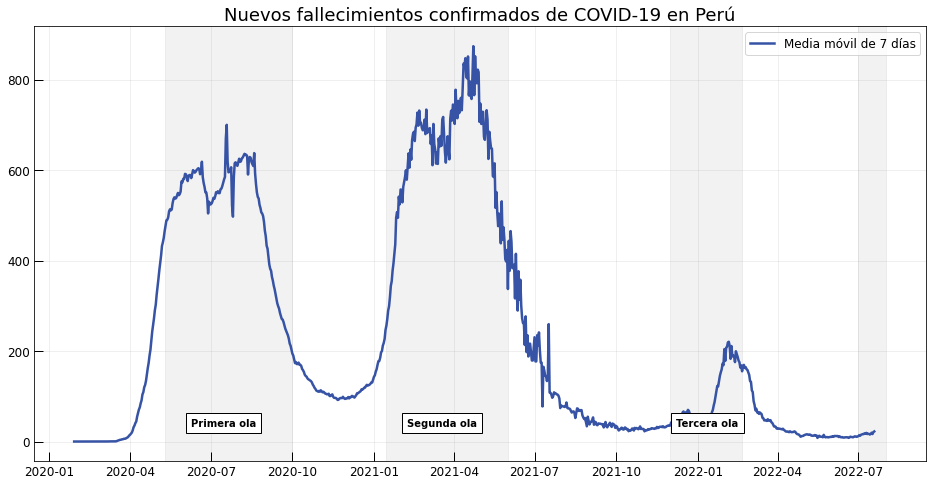

In [17]:
plt.figure(figsize=(16, 8), linewidth = 2.5)

#Gráficas
# plt.plot(peru_data.index, peru_data["Nuevas Muertes"], label = "Nuevos fallecimientos diarios", linewidth = 2.5)
plt.plot(peru_data.index, peru_data["Nuevas Muertes MA7"], label = "Media móvil de 7 días", color = "#3653A5", linewidth = 2.5)

#Barras de olas
plt.axvspan("2020-05-10", "2020-10", alpha=0.1, color="grey")
plt.axvspan("2021-01-15", "2021-06", alpha=0.1, color="grey")
plt.axvspan("2021-12", "2022-02-20", alpha=0.1, color="grey")
plt.axvspan("2022-07", "2022-08", alpha=0.1, color="grey")

#Box of text
plt.text(datetime.date(2020, 7, 15), 40, "Primera ola", ha="center", va="center", weight = "bold",
         bbox = dict(facecolor="white", boxstyle="square", edgecolor="black", pad=0.5))
plt.text(datetime.date(2021, 3, 19), 40, "Segunda ola", ha="center", va="center", weight = "bold",
         bbox = dict(facecolor="white", boxstyle="square", edgecolor="black", pad=0.5))
plt.text(datetime.date(2022, 1, 12), 40, "Tercera ola", ha="center", va="center", weight = "bold",
         bbox = dict(facecolor="white", boxstyle="square", edgecolor="black", pad=0.5))

#Editando ticks
plt.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)

#Detalles adicionales
plt.title("Nuevos fallecimientos confirmados de COVID-19 en Perú", fontsize = 18)
plt.grid(True, alpha=0.25)
plt.legend(fontsize = 12)


plt.savefig("./graphs/muertes-covid-peru.pdf")
plt.show()

Aunque, es más informativo graficarlos en conjunto para observar el grado de mortalidad de cada una de las olas. En este caso, se graficará el promedio 

In [18]:
peru_data_semanal = peru_data.reset_index()
peru_data_semanal = peru_data_semanal.groupby(pd.Grouper(key='index', freq='W')).mean()

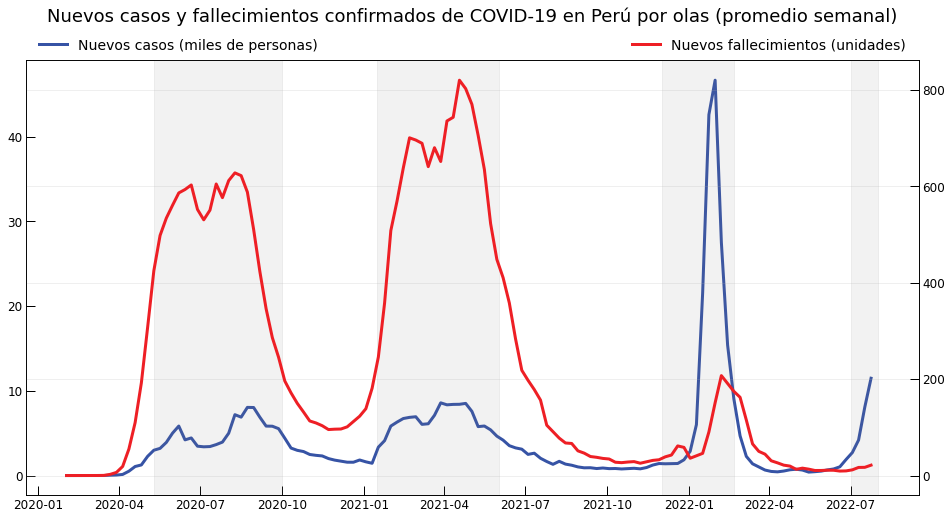

In [19]:
fig, ax1 = plt.subplots(figsize=(16, 8), linewidth = 2.5)
ax2 = ax1.twinx()


#Gráficas
ax1.plot(peru_data_semanal.index, peru_data_semanal["Nuevos Casos MA7"], label = "Nuevos casos (miles de personas)",
         color = "#3653A5", linewidth = 3)
ax2.plot(peru_data_semanal.index, peru_data_semanal["Nuevas Muertes MA7"], label = "Nuevos fallecimientos (unidades)",
         color = "#EE1F25", linewidth = 3)

#Barras de olas
plt.axvspan("2020-05-10", "2020-10", alpha=0.1, color="grey")
plt.axvspan("2021-01-15", "2021-06", alpha=0.1, color="grey")
plt.axvspan("2021-12", "2022-02-20", alpha=0.1, color="grey")
plt.axvspan("2022-07", "2022-08", alpha=0.1, color="grey")

#Posicionando las leyendas
ax1.legend(bbox_to_anchor=(0, 1.08), loc = 'upper left', fontsize=14, frameon=False)
ax2.legend(bbox_to_anchor=(1, 1.08), loc = 'upper right', fontsize=14, frameon=False)

#Editando los ticks
ax1.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
ax2.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)

#Detalles adicionales
plt.text(0.5, 1.09, "Nuevos casos y fallecimientos confirmados de COVID-19 en Perú por olas (promedio semanal)",
         horizontalalignment='center', fontsize=18, transform = ax1.transAxes)
plt.grid(True, alpha=0.25)


plt.savefig("./graphs/covid-peru.pdf")

plt.show()

Como se puede observar en la gráfica, la tercera ola ha generado un acelerado aumento de los nuevos casos diarios, muy superior a la primera y segunda ola. Sin embargo, la cantidad de fallecidos ha sido muy por debajo de las cifras de previas olas, en línea con el avance en la vacunación

### Covid in Bolivia

Al igual que en el Perú, se puede replicar los resultados para otros países como Bolivia, el cual sigue rezagado en el avance de la vacunación

In [20]:
bolivia_data = latam_cases[["Bolivia"]].rename(columns = {"Bolivia": "Casos"})
bolivia_data = pd.concat([bolivia_data, latam_deaths["Bolivia"]], axis = 1)

bolivia_data.rename(columns = {"Bolivia": "Muertes"}, inplace = True)

bolivia_data["Nuevos Casos"] = bolivia_data["Casos"] - bolivia_data["Casos"].shift(1)
bolivia_data["Nuevas Muertes"] = bolivia_data["Muertes"] - bolivia_data["Muertes"].shift(1)

bolivia_data = bolivia_data.replace('NaN', np.NaN)
bolivia_data[["Casos", "Nuevos Casos"]] = bolivia_data[["Casos", "Nuevos Casos"]]/1000
bolivia_data.reset_index(inplace=True)

#Promedio semanal
bolivia_data = bolivia_data.groupby(pd.Grouper(key='index', freq='W')).mean()
bolivia_data.drop(bolivia_data.tail(1).index,inplace=True)

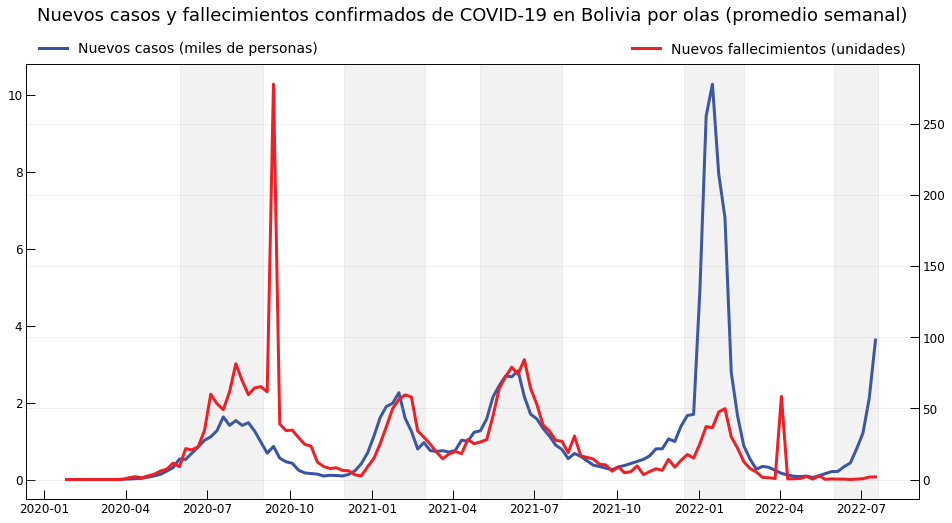

In [21]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()


#Gráficas
ax1.plot(bolivia_data.index, bolivia_data["Nuevos Casos"], label = "Nuevos casos (miles de personas)",
         color = "#3653A5", linewidth = 3)
ax2.plot(bolivia_data.index, bolivia_data["Nuevas Muertes"], label = "Nuevos fallecimientos (unidades)",
         color = "#EE1F25", linewidth = 3)

#Barras de olas
plt.axvspan("2020-06", "2020-09", alpha=0.1, color="grey")
plt.axvspan("2020-12", "2021-03", alpha=0.1, color="grey")
plt.axvspan("2021-05", "2021-08", alpha=0.1, color="grey")
plt.axvspan("2021-12-15", "2022-02-20", alpha=0.1, color="grey")
plt.axvspan("2022-06-01", "2022-07-20", alpha=0.1, color="grey")

#Posicionando las leyendas
ax1.legend(bbox_to_anchor=(0, 1.08), loc = 'upper left', fontsize=14, frameon=False)
ax2.legend(bbox_to_anchor=(1, 1.08), loc = 'upper right', fontsize=14, frameon=False)

#Editando los ticks
ax1.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
ax2.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)

#Detalles adicionales
plt.text(0.5, 1.10, "Nuevos casos y fallecimientos confirmados de COVID-19 en Bolivia por olas (promedio semanal)",
         horizontalalignment='center', fontsize=18, transform = ax1.transAxes)
plt.grid(True, alpha=0.25)


plt.savefig("./graphs/casos-covid-bolivia.pdf")
plt.show()

In [22]:
bolivia_data.to_excel("./data/bolivia-covid.xlsx")